In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from more_itertools import padded
import sys
import math

from IPython.display import Markdown as md

## Read Data

In [2]:
names = []
nameasc = []
genders = []
probs = []
maxlen = 0

f = open("name_gender.csv")
data = f.readlines()
f.close()
for line in data:
    name, gender, prob = line.split(',')
    names.append(name.lower())
    if name.__len__() > maxlen:
        maxlen = name.__len__()
    nameasc.append([ord(ch) for ch in name.lower()])
    genders.append([1,0] if gender == 'M' else [0,1])
    probs.append(np.float16(prob.strip("\n")))

cleanup

In [3]:
del name, data, gender, prob
nameasc_ = nameasc.copy()

## Arrayfy

In [4]:
names = np.array(names)
genders = np.array(genders, dtype=np.int8)
probs = np.array(probs, dtype=np.float16)

## Check alphabets

In [5]:
alphabetsMale = ''
alphabetsFeml = ''
for name,gender in zip(names,genders):
    if gender[0] > 0:
        alphabetsMale += name
    else:
        alphabetsFeml += name
alphabetsFeml = Counter(alphabetsFeml)
alphabetsMale = Counter(alphabetsMale)

Plot vowels

In [6]:
vowels = ['a','e','i','o','u']
maleVowel = {key: alphabetsMale[key] for key in alphabetsMale.keys() if key in vowels}
maleVowel = {key: maleVowel[key] / sum(maleVowel.values()) for key in maleVowel.keys()}
femlVowel = {key: alphabetsFeml[key] for key in alphabetsFeml.keys() if key in vowels}
femlVowel = {key: femlVowel[key] / sum(femlVowel.values()) for key in femlVowel.keys()}

In [7]:
maleVowel, femlVowel

({'a': 0.3300480190701033,
  'i': 0.1854292492292882,
  'e': 0.25851221105470046,
  'o': 0.1571335251040031,
  'u': 0.06887699554190495},
 {'a': 0.4347808988764045,
  'i': 0.2093876404494382,
  'e': 0.2628595505617978,
  'o': 0.06066292134831461,
  'u': 0.03230898876404494})

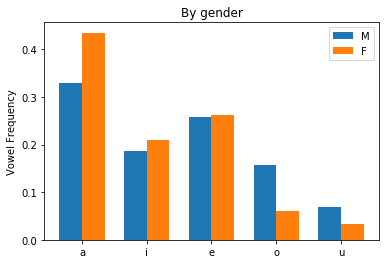

In [8]:
x = np.arange(len(maleVowel.keys()))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, maleVowel.values(), width, label='M')
rects2 = ax.bar(x + width/2, femlVowel.values(), width, label='F')
ax.set_ylabel('Vowel Frequency')
ax.set_title('By gender')
ax.set_xticks(x)
ax.set_xticklabels(maleVowel.keys())
ax.legend()
plt.show()

Females has more vowels of type a,i,e in her names while males has more vowels of type o,u in his name<br/>
We can do much more analysis. This is just an introduction. But the intention here is to build a model

cleanup

In [9]:
del vowels, maleVowel, femlVowel, x, width, fig, ax, name, gender

## Simple Features

In [10]:
for idx in range(nameasc.__len__()):
    nameasc[idx] = ( maxlen - nameasc[idx].__len__() ) * [0] + nameasc[idx]

In [11]:
md("We see that %i is the maximum name size. Thus we sequence a callback lookup for LSTM upto 15 alphabets"%(maxlen))

We see that 15 is the maximum name size. Thus we sequence a callback lookup for LSTM upto 15 alphabets

In [12]:
nameasc = np.array(nameasc)

In [13]:
nameasc[nameasc > 0].min(), nameasc[nameasc > 0].max()

(97, 122)

In [14]:
assert alphabetsFeml.__len__() == alphabetsMale.__len__()

In [15]:
nameasc -= 96
indx = (nameasc < 0)

In [16]:
nameasc[indx] = 0

In [17]:
nameasc

array([[ 0,  0,  0, ...,  2,  1, 14],
       [ 0,  0,  0, ...,  2,  8,  1],
       [ 0,  0,  0, ...,  2,  9,  4],
       ...,
       [ 0,  0,  0, ..., 14, 14,  1],
       [ 0,  0,  0, ..., 25, 15, 14],
       [ 0,  0,  0, ..., 25, 26, 24]])

In [18]:
nameasc.shape

(95025, 15)

We will now expand the 15 len rows to 27 * 15 tensor

In [19]:
tensorasc = []
for ascname in nameasc:
    tensornm = []
    for num in ascname:
        tmparr = [0]*27
        tmparr[num] = 1
        tensornm.append(tmparr)
    tensorasc.append(tensornm)
tensorasc = np.array(tensorasc)

In [20]:
tensorasc

array([[[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

## Test Train Split

In [21]:
np.random.seed(42)
test_indices = np.random.choice(range(names.__len__()), math.ceil(0.3*names.__len__()), replace=False)

In [22]:
vald_indices = np.random.choice(test_indices, math.ceil(0.5*test_indices.__len__()), replace=False)

In [23]:
X_test = tensorasc[test_indices]
Y_test = genders[test_indices]

In [24]:
X_vald = tensorasc[vald_indices]
Y_vald = genders[vald_indices]

In [25]:
train_indices = np.ones(names.__len__(), dtype=bool)
train_indices[test_indices] = False
X_train = tensorasc[train_indices]
Y_train = genders[train_indices]

## Model

In [2]:
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [27]:
model = Sequential()
model.add(LSTM(270, return_sequences=False, input_shape=(15, 27)))
model.add(Dropout(0.15))
model.add(Dense(units=2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [28]:
callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)
history = model.fit(X_train, Y_train, batch_size=1000, epochs=50, validation_data=(X_vald, Y_vald), callbacks=[callback])

Train on 66517 samples, validate on 14254 samples
Epoch 1/50
66517/66517 [==============================] - 21s 313us/step - loss: 0.5537 - acc: 0.7082 - val_loss: 0.4182 - val_acc: 0.8093
Epoch 2/50
66517/66517 [==============================] - 20s 304us/step - loss: 0.3991 - acc: 0.8225 - val_loss: 0.3871 - val_acc: 0.8264
Epoch 3/50
66517/66517 [==============================] - 19s 292us/step - loss: 0.3810 - acc: 0.8314 - val_loss: 0.3745 - val_acc: 0.8325
Epoch 4/50
66517/66517 [==============================] - 18s 278us/step - loss: 0.3764 - acc: 0.8334 - val_loss: 0.3695 - val_acc: 0.8347
Epoch 5/50
66517/66517 [==============================] - 20s 302us/step - loss: 0.3690 - acc: 0.8367 - val_loss: 0.3696 - val_acc: 0.8337
Epoch 6/50
66517/66517 [==============================] - 19s 290us/step - loss: 0.3647 - acc: 0.8397 - val_loss: 0.3601 - val_acc: 0.8394
Epoch 7/50
66517/66517 [==============================] - 19s 280us/step - loss: 0.3572 - acc: 0.8426 - val_loss: 0.

In [29]:
y_pred = model.predict_classes(X_test)

In [30]:
y_test = ( Y_test[:,1] > 0 ) * 1

In [31]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
print(confusion_matrix(y_test, y_pred))

[[ 9155  1295]
 [ 1693 16365]]


In [32]:
print(f"Precision: {precision_score(y_test, y_pred)}\nRecall:    {recall_score(y_test,y_pred)}\nF1:        {f1_score(y_test, y_pred)}\nAccuracy:  {accuracy_score(y_test, y_pred)}")

Precision: 0.9266704416761042
Recall:    0.9062465389301141
F1:        0.9163447001511843
Accuracy:  0.8951873158411674


In [33]:
model.save("assets\models\LSTMSimple")

In [3]:
from tensorflow.keras.models import load_model
loadedModel = load_model("assets\models\LSTMSimple")

In [5]:
loadedModel.save("assets\models\LSTMSimple",save_format="h5")

In [35]:
assert np.all(loadedModel.predict_classes(X_test) == y_pred)

In [1]:
!pip freeze

absl-py==0.9.0
alabaster==0.7.12
anaconda-client==1.7.2
anaconda-navigator==1.9.7
anaconda-project==0.8.3
asn1crypto==1.0.1
astor==0.8.0
astroid==2.3.1
astropy==3.2.1
astunparse==1.6.3
atomicwrites==1.3.0
attrs==19.2.0
Babel==2.7.0
backcall==0.1.0
backports.functools-lru-cache==1.5
backports.os==0.1.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.8.0
bitarray==1.0.1
bkcharts==0.2
bleach==3.1.0
blinker==1.4
bokeh==1.3.4
boto==2.49.0
Bottleneck==1.2.1
cachetools==3.1.1
certifi==2019.9.11
cffi==1.12.3
chardet==3.0.4
Click==7.0
cloudpickle==1.2.2
clyent==1.2.2
colorama==0.4.1
comtypes==1.1.7
conda==4.8.3
conda-build==3.18.9
conda-package-handling==1.6.0
conda-verify==3.4.2
contextlib2==0.6.0
cryptography==2.7
cycler==0.10.0
Cython==0.29.13
cytoolz==0.10.0
dask==2.5.2
decorator==4.4.0
defusedxml==0.6.0
distributed==2.5.2
docutils==0.15.2
entrypoints==0.3
et-xmlfile==1.0.1
fastcache==1.1.0
filelock==3.0.12
Flask==1.1.1
flatbu